In [37]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tqdm as tqdm
import sys

sys.path.append('..')
import interpolator
import pyvo

import pyphot

#sys.path.append('../..')
#import wdtools_nicole as wdtools

import sys, os
wdmodels_dir = os.environ['WDMODELS_DIR']
sys.path.append(wdmodels_dir)
import WD_models

plt.style.use('stefan.mplstyle')

In [38]:
"""compute the radial velocity from radius and effective temperature
"""
mass_sun, radius_sun, newton_G, speed_light = 1.9884e30, 6.957e8, 6.674e-11, 299792458
font_model = WD_models.load_model('f', 'f', 'f', 'H')
g_acc = (10**font_model['logg'])/100
rsun = np.sqrt(font_model['mass_array'] * mass_sun * newton_G / g_acc) / radius_sun
logg_function = WD_models.interp_xy_z_func(x = 10**font_model['logteff'], y = font_model['logg'],\
                                            z = rsun, interp_type = 'linear')

In [39]:
test = interpolator.atmos.WarwickSpectrum('1d_db_nlte', units='flam')

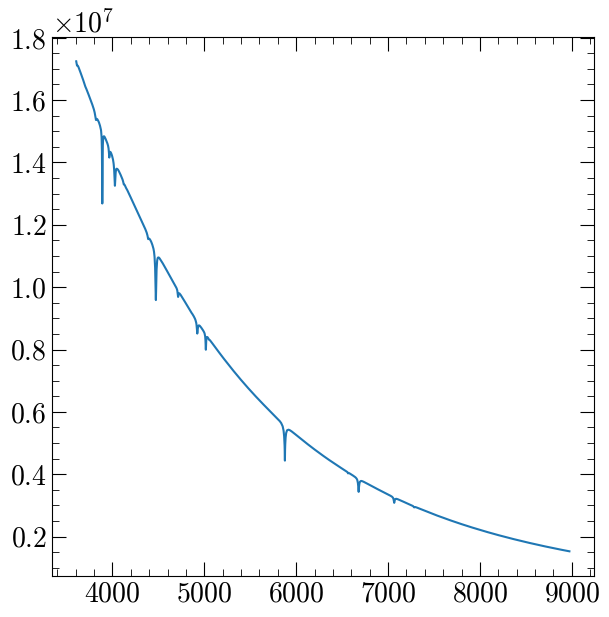

In [40]:
plt.plot(test.wavl, test(12000, 8, 8))

In [41]:
"""build the model SED using default filters
"""
defaults = interpolator.atmos.sed.get_default_filters({'zerofile' : 'alpha_lyr_stis_011'})
SED = interpolator.atmos.WarwickPhotometry('1d_db_nlte', [defaults['Gaia_G'], defaults['Gaia_BP'], defaults['Gaia_RP']], units = 'flam', fixedhe=5)
interp, _, (T, L, A, grid_sansav, grid) = SED.make_cache(nAV=40)
SED.zeropoints

array([21.50298444, 20.97310752, 22.2411774 ])

In [42]:
theta = [10000, 8.001777261158344, 100, 0]
interpolator.fit.get_model_flux(theta, interp, logg_function=logg_function), 

(array([1.26514483e-10, 2.01952381e-10, 6.89898983e-11]),)

In [43]:
4*np.pi*interp(23507, 8.16) * ((0.0128*6.957e8)**2 / (220.98*3.08568e16)**2)

array([3.40592791e-16, 6.12684021e-16, 1.45856269e-16])

In [44]:
theta = [10000, 0.01281575, 100, 0, 0.6]
interpolator.fit.get_model_flux(theta, interp, logg_function=None), 

(array([3.11796325e-16, 4.97728147e-16, 1.70689009e-16]),)

In [45]:
logg= np.log10(100*(newton_G * mass_sun * 0.6) / (0.0128 * radius_sun)**2)
rad2 = logg_function(10000, logg)
rad2

array(0.01281575)

In [46]:
# array([21.50762303, 20.97943774, 22.24345324])

In [47]:
def mag_to_flux(mag : np.array, e_mag : np.array):
    """convert vega magnitudes to fluxes in flam units
    """
    flux = np.power(10, -0.4*(mag - np.array([-21.48503, -20.96683, -22.22089])))  
    e_flux = 1.09 * flux * e_mag
    return flux, e_flux

def loss(params, fl, e_fl, plx, av):
    pc_to_m, radius_sun = 3.08568e16, 6.957e8
    teff, logg = params.valuesdict().values()
    theta = np.array([teff, logg, 1000 / plx, 0])
    flux_model = interpolator.fit.get_model_flux(theta, interp, logg_function=logg_function)
    return (fl - flux_model) / e_fl

In [58]:
tap_service = pyvo.dal.TAPService("http://TAPVizieR.u-strasbg.fr/TAPVizieR/tap/")
QUERY = f"""select top 1000 *
        from \"J/MNRAS/508/3877/maincat\"
        where TeffH is not NULL and MassH is not NULL and meanAV is not NULL and RPlx > 3
        """
ngfdata = tap_service.search(QUERY).to_table().to_pandas()

In [59]:
ngfdata[['GmagCorr', 'BPmag', 'RPmag']]

,GmagCorr,BPmag,RPmag
0,18.841656,19.1983,18.4692
1,17.980106,18.0001,17.9989
2,20.544395,20.3948,20.0208
3,19.558094,19.7312,19.4493
4,17.467531,17.4906,17.5178
...,...,...,...
995,19.185688,19.5460,18.7499
996,20.276382,20.2494,20.2590
997,19.583485,19.6540,19.4422
998,17.165180,17.0587,17.3631


In [60]:
import lmfit

values = np.zeros((len(ngfdata), 4))
for i, row in tqdm.tqdm(ngfdata.iterrows(), total=len(ngfdata)):
    extinction = np.array([0.835*row.meanAV, 1.139*row.meanAV, 0.650*row.meanAV])
    mags = row[['GmagCorr', 'BPmag', 'RPmag']].values - extinction# + 5*(np.log10((row.Plx - row.ZPcor)*1e-3) + 1)
    e_mags = row[['e_GmagCorr', 'e_BPmag', 'e_RPmag']].values
    #fluxes, e_fluxes = SED.mag_to_flux(mags, e_mags)
    fluxes, e_fluxes = mag_to_flux(mags, e_mags)

    params = lmfit.Parameters()
    params.add('teff', value=10000, min=2000, max=50000, vary=True)
    params.add('logg', value=8, min=7.15, max=9, vary=True)

    res = lmfit.minimize(loss, params, args = (fluxes, e_fluxes, row.Plx - row.ZPcor, 0))
    teff, logg = res.params['teff'].value, res.params['logg'].value
    values[i,0] = row.GaiaEDR3
    values[i,1] = teff
    values[i,2] = logg
    values[i,3] = res.redchi
leastsq = pd.DataFrame(values, columns=['GaiaEDR3', 'teff', 'logg', 'redchi'])

100%|██████████| 1000/1000 [00:10<00:00, 95.96it/s]


In [61]:
leastsq

,GaiaEDR3,teff,logg,redchi
0,7.469807e+13,4791.528487,7.15,7.035006e+12
1,1.529352e+14,4747.073310,7.15,1.446727e+11
2,2.519256e+14,4772.883059,7.15,1.569131e+11
3,2.626802e+14,4791.042549,7.15,6.089197e+11
4,2.881751e+14,4750.349874,7.15,3.422289e+11
...,...,...,...,...
995,4.423170e+16,4788.938603,7.15,2.909162e+12
996,4.425033e+16,4787.269886,7.15,6.420021e+10
997,4.426410e+16,4787.227392,7.15,5.559407e+10
998,4.426675e+16,4700.129224,7.15,9.150901e+08


In [52]:
def interpolate_massteff(massarray : np.array, teffarray : np.array, Hlayer : str = 'thick') -> np.array:
    """compute the radial velocity from mass and effective temperature
    """
    assert Hlayer in ['thick', 'thin'], 'Hlayer must be either "thick" or "thin"'
    mass_sun, radius_sun, newton_G, speed_light = 1.9884e30, 6.957e8, 6.674e-11, 299792458
    font_model = WD_models.load_model('f', 'f', 'f', 'H') if Hlayer == 'thick' else WD_models.load_model('f', 'ft', 'f', 'H')
    g_acc = (10**font_model['logg'])/100
    rsun = np.sqrt(font_model['mass_array'] * mass_sun * newton_G / g_acc) / radius_sun
    mass_teff_to_radius = WD_models.interp_xy_z_func(x = font_model['mass_array'], y = 10**font_model['logteff'],\
                                                z = rsun, interp_type = 'linear')
    radius = mass_teff_to_radius(massarray, teffarray)
    return radius

ngfdata['RadiusH'] = interpolate_massteff(ngfdata.Massmix.values, ngfdata.Teffmix.values, Hlayer = 'thick')
leastsq['radius'] = logg_function(leastsq.teff, leastsq.logg)
leastsq['mass'] = (1e-2*10**leastsq.logg * ((leastsq.radius*radius_sun)**2 / newton_G))/mass_sun
leastsq = leastsq.query("mass > 0.46")

In [53]:
comparison = pd.merge(leastsq, ngfdata, on='GaiaEDR3')
comparison['teff_pct_err'] = (comparison.teff - comparison.Teffmix) / comparison.teff * 100
comparison['logg_pct_err'] = (comparison.logg - comparison.loggmix) / comparison.logg * 100
comparison['ngf_dist'] = 1000 / (comparison.Plx + comparison.ZPcor)

/tmp/ipykernel_1082729/1132919249.py:17: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax_histx.set_yscale('log')
/tmp/ipykernel_1082729/1132919249.py:18: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax_histy.set_xscale('log')


(-10.0, 10.0)

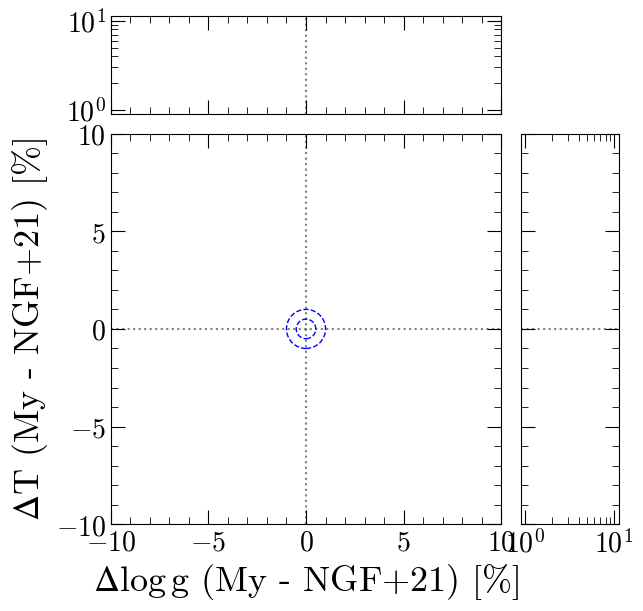

In [54]:
import matplotlib.patches as patches

def scatter_hist(x, y, ax, ax_histx, ax_histy):
    # no labels
    ax_histx.tick_params(axis="x", labelbottom=False)
    ax_histy.tick_params(axis="y", labelleft=False)
    # the scatter plot:
    scatter = ax.scatter(x, y, c='k', s = 5)
    ax.axhline(y = 0, ls = ':', alpha = 0.5, c = 'k')
    ax.axvline(x = 0, ls = ':', alpha = 0.5, c = 'k')
    # now determine nice limits by hand:
    binwidth = 0.5
    ax_histx.hist(x, color = 'k', histtype = 'step')
    ax_histx.axvline(x = 0, ls = ':', alpha = 0.5, c = 'k')
    ax_histy.hist(y, orientation='horizontal', color = 'k', histtype = 'step')
    ax_histy.axhline(y = 0, ls = ':', alpha = 0.5, c = 'k')
    ax_histx.set_yscale('log')
    ax_histy.set_xscale('log')
    return scatter

fig = plt.figure(layout='constrained', figsize=(8,6))
ax = fig.add_gridspec(top=0.75, right=0.75).subplots()
ax.set(aspect=1)

ax_histx = ax.inset_axes([0, 1.05, 1, 0.25], sharex=ax)
ax_histy = ax.inset_axes([1.05, 0, 0.25, 1], sharey=ax)

temp_compare = comparison.copy()
scatter_mass = scatter_hist(temp_compare.logg_pct_err, temp_compare.teff_pct_err, ax = ax, 
                            ax_histx = ax_histx, ax_histy = ax_histy)
confidence_ellipses = [0.5, 1]
for val in confidence_ellipses:
    circle = patches.Circle((0, 0), val, edgecolor='blue', facecolor='none', ls = '--', linewidth=1, label='')
    ax.add_patch(circle)
ax.set_xlabel(r'$\Delta \log g$ (My - NGF+21) [%]')
ax.set_ylabel(r'$\Delta T$ (My - NGF+21) [%]')
ax.set_xlim(-10,10)
ax.set_ylim(-10,10)

In [55]:
10**(-0.4*SED.zeropoints)

array([2.50499131e-09, 4.08090977e-09, 1.26919700e-09])

In [56]:
-2.5*np.log10([2.49e-9, 4.04e-9, 1.28e-9])

array([21.50950163, 20.98404659, 22.23197508])